In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from datetime import datetime

#imports from sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn import metrics
from sklearn import svm
from sklearn.neural_network import MLPRegressor
from sklearn.impute import KNNImputer

In [2]:
df = pd.read_csv("training.csv", sep='\s+')

In [3]:
print(f"Number of rows: {len(df)}")
print(f"Colums: {[column for column in df.columns]}")

Number of rows: 29731
Colums: ['DepartureDate', 'DepartureYear', 'DepartureMonth', 'DepartureDay', 'FlightNumber', 'DepartureAirport', 'ArrivalAirport', 'Route', 'ActualFlightTime', 'ActualTotalFuel', 'ActualTOW', 'FLownPassengers', 'BagsCount', 'FlightBagsWeight']


In [4]:
df.head(3)

,DepartureDate,DepartureYear,DepartureMonth,DepartureDay,FlightNumber,DepartureAirport,ArrivalAirport,Route,ActualFlightTime,ActualTotalFuel,ActualTOW,FLownPassengers,BagsCount,FlightBagsWeight
0,01/10/2016,2016,10,1,1145,MAN,SXF,MAN-SXF,91,3660,64016,175,61,440
1,01/10/2016,2016,10,1,1160,CTA,FCO,CTA-FCO,68,3280,66138,182,27,350
2,01/10/2016,2016,10,1,1183,LGW,SNN,LGW-SNN,64,2720,58447,127,(null),(null)


| feature name | feature type | comments |
| --- | --- | --- |
| DepartureDate | timestamp | date of departure |
| DepartureYear | numerical | year of departure |
| DepartureMonth | numerical | month of departure |
| DepartureDay | numerical | day of departure |
| FlightNumber | numerical | fight number |
| DepartureAirport | text | departure airport code |
| ArrivalAirport | text | arrival airport code |
| Route | text  | route in type (departure airport code -  rrival airport code) |
| ActualFlightTime | numerical | flight time (probably in a minute) |
| ActualTotalFuel | numerical | burnt fuel |
| ActualTOW | numerical | take-off weight (kg) |
| FlownPassengers | numerical | count of flown passengers |
| BagsCount | numerical | count of baggage in a plane |
| FlightBagsWeight | numerical | flown bags weight |

## Cleaning

In [5]:
df = df.replace("(null)",np.nan)
missing_df = df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['variable', 'missing values']
missing_df['filling factor (%)']=(df.shape[0]-missing_df['missing values'])/df.shape[0]*100
missing_df.sort_values('filling factor (%)').reset_index(drop = True)

,variable,missing values,filling factor (%)
0,FlightBagsWeight,2478,91.665265
1,BagsCount,2284,92.317783
2,ActualTOW,433,98.543608
3,FLownPassengers,95,99.680468
4,DepartureDate,0,100.000000
5,DepartureYear,0,100.000000
6,DepartureMonth,0,100.000000
7,DepartureDay,0,100.000000
8,FlightNumber,0,100.000000
9,DepartureAirport,0,100.000000


Based on the observed filling factor of (> 91.5%) for the variables, I have decided to examine whether there are rows in the data that contain more than one NaN value.

In [6]:
# Create a boolean mask indicating NaN values in each row
nan_mask = df.isna()

# Count the number of True values (NaNs) in each row
nan_count = nan_mask.sum(axis=1)

# Filter rows where the count of NaN values is greater than 1
rows_with_multiple_nan = df[nan_count > 1]

# Print the rows with more than one NaN value
rows_with_multiple_nan

,DepartureDate,DepartureYear,DepartureMonth,DepartureDay,FlightNumber,DepartureAirport,ArrivalAirport,Route,ActualFlightTime,ActualTotalFuel,ActualTOW,FLownPassengers,BagsCount,FlightBagsWeight
2,01/10/2016,2016,10,1,1183,LGW,SNN,LGW-SNN,64,2720,58447,127,NaN,NaN
7,01/10/2016,2016,10,1,1273,BFS,LGW,BFS-LGW,69,2940,62836,161,NaN,NaN
35,01/10/2016,2016,10,1,2508,CGN,BCN,CGN-BCN,117,5397,67498,185,NaN,NaN
39,01/10/2016,2016,10,1,2622,PDL,LIS,PDL-LIS,109,4920,66573,180,NaN,NaN
46,01/10/2016,2016,10,1,3064,TFN,BCN,TFN-BCN,172,7043,67752,177,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29630,15/10/2016,2016,10,15,5272,SVQ,PMI,SVQ-PMI,75,3070,64215,179,NaN,NaN
29636,15/10/2016,2016,10,15,5482,MAD,OPO,MAD-OPO,54,2360,62619,170,NaN,NaN
29644,15/10/2016,2016,10,15,6025,OTP,ATH,OTP-ATH,80,3633,64342,169,NaN,NaN
29656,15/10/2016,2016,10,15,6578,BCN,PMI,BCN-PMI,27,1480,62437,160,NaN,NaN


Based on our observations, it has been determined that a significant portion of the rows in the data contain multiple NaN values. Consequently, I have made the decision to remove any rows that have more than one missing value.

In [7]:
df_nan = df.drop(rows_with_multiple_nan.index)
missing_df = df_nan.isnull().sum(axis=0).reset_index()
missing_df.columns = ['variable', 'missing values']
missing_df['filling factor (%)']=(df_nan.shape[0]-missing_df['missing values'])/df_nan.shape[0]*100
missing_df.sort_values('filling factor (%)').reset_index(drop = True)

,variable,missing values,filling factor (%)
0,ActualTOW,342,98.758711
1,FlightBagsWeight,301,98.907520
2,BagsCount,109,99.604384
3,DepartureDate,0,100.000000
4,DepartureYear,0,100.000000
5,DepartureMonth,0,100.000000
6,DepartureDay,0,100.000000
7,FlightNumber,0,100.000000
8,DepartureAirport,0,100.000000
9,ArrivalAirport,0,100.000000


In [11]:
numerical_columns = ['DepartureYear', 'DepartureMonth', 'DepartureDay', 'FlightNumber', 'ActualFlightTime', 
                     'ActualTotalFuel', 'ActualTOW', 'FLownPassengers', 'BagsCount', 'FlightBagsWeight']
for column in numerical_columns:
    df_nan[column] = pd.to_numeric(df_nan[column])

In [12]:
df_nan = df_nan.dropna(subset = ["ActualTOW"])
#Finding the mean of the column having NaN
mean_value_1 = df_nan['FlightBagsWeight'].mean()
mean_value_2 = df_nan['BagsCount'].mean()
# Replace NaNs in column S2 with the
# mean of values in the same column
df_nan['FlightBagsWeight'].fillna(value=mean_value_1, inplace=True)
df_nan['BagsCount'].fillna(value=mean_value_2, inplace=True)

In [15]:
df_nan = df_nan.dropna(subset = ["ActualTOW"])
# Create an instance of the KNNImputer with the desired number of neighbors
knn_imputer = KNNImputer(n_neighbors=5)

# Perform KNN imputation on the selected columns
df_nan[['BagsCount', 'FlightBagsWeight']] = knn_imputer.fit_transform(df_nan[['BagsCount', 'FlightBagsWeight']])

Based on my observations, it has been determined that a few NaN values still remain in the dataset. After analyzing the missing data and looking on feature importance in future model, it has been concluded that the best approach is to remove the remaining rows that contain NaN values from our dataset.

In [16]:
df = df.dropna()
print("Number of rows after deliting missing data:", len(df))
missing_df = df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['variable', 'missing values']
missing_df['filling factor (%)']=(df.shape[0]-missing_df['missing values'])/df.shape[0]*100
missing_df.sort_values('filling factor (%)').reset_index(drop = True)

Number of rows after deliting missing data: 26800


,variable,missing values,filling factor (%)
0,DepartureDate,0,100.0
1,DepartureYear,0,100.0
2,DepartureMonth,0,100.0
3,DepartureDay,0,100.0
4,FlightNumber,0,100.0
5,DepartureAirport,0,100.0
6,ArrivalAirport,0,100.0
7,Route,0,100.0
8,ActualFlightTime,0,100.0
9,ActualTotalFuel,0,100.0


Due to the non-typical representation of NaNs, such as "(null)", our columns are being read as strings. To address this, I have converted their data type to numeric:

In [71]:
df = pd.read_csv("training.csv", sep='\s+')
df = df.replace("(null)",np.nan)
df = df.dropna()
numerical_columns = ['DepartureYear', 'DepartureMonth', 'DepartureDay', 'FlightNumber', 'ActualFlightTime', 
                     'ActualTotalFuel', 'ActualTOW', 'FLownPassengers', 'BagsCount', 'FlightBagsWeight']
for column in numerical_columns:
    df[column] = pd.to_numeric(df[column])

## EDA

### correlation matrix

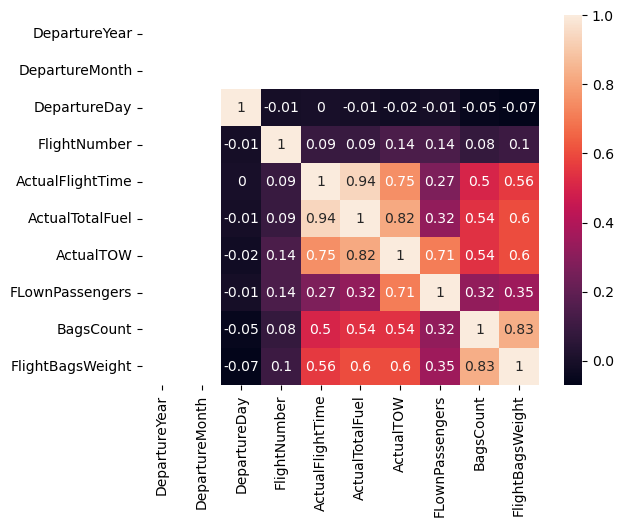

In [28]:
corrmat = df[numerical_columns].corr().round(2)
f, ax = plt.subplots()
sns.heatmap(corrmat, annot=True)
plt.show()

Plotting the features with the target value:

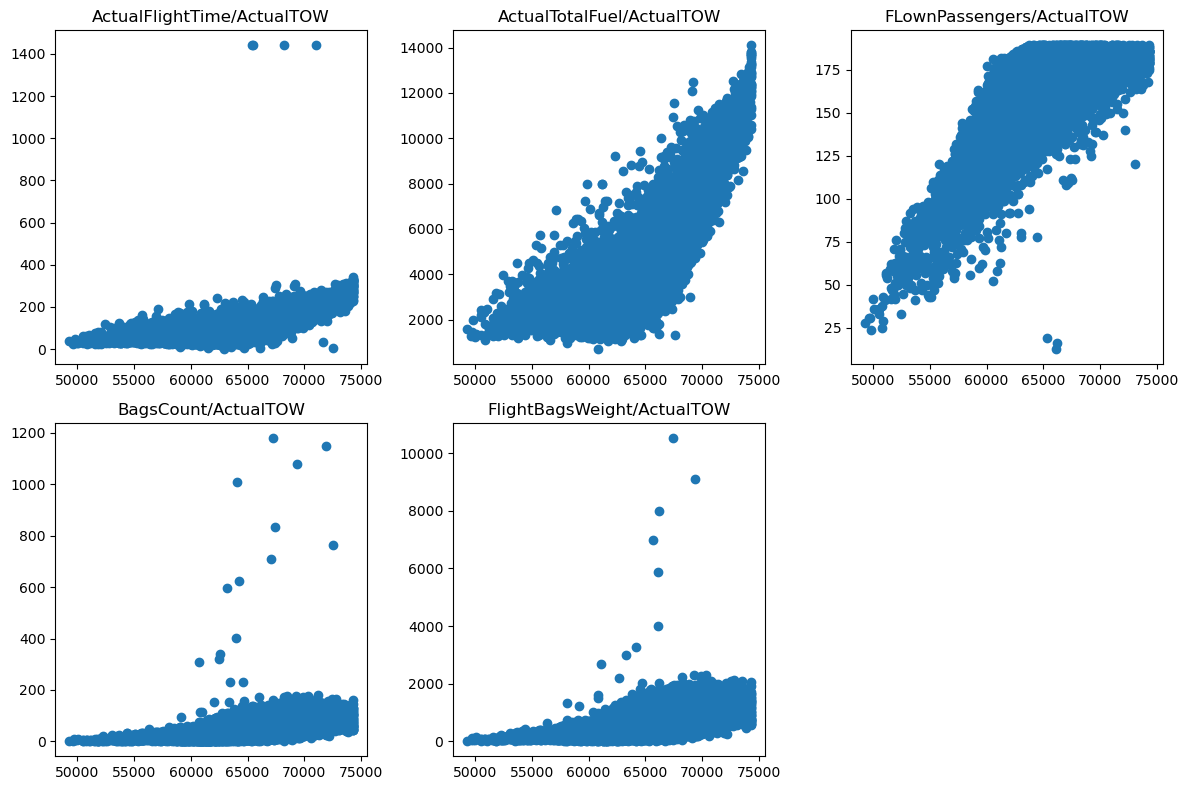

In [29]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Scatter plots
axes[0].scatter(df['ActualTOW'], df["ActualFlightTime"])
axes[0].set_title("ActualFlightTime/ActualTOW")

axes[1].scatter(df['ActualTOW'], df["ActualTotalFuel"])
axes[1].set_title("ActualTotalFuel/ActualTOW")

axes[2].scatter(df['ActualTOW'], df["FLownPassengers"])
axes[2].set_title("FLownPassengers/ActualTOW")

axes[3].scatter(df['ActualTOW'], df["BagsCount"])
axes[3].set_title("BagsCount/ActualTOW")

axes[4].scatter(df['ActualTOW'], df["FlightBagsWeight"])
axes[4].set_title("FlightBagsWeight/ActualTOW")

# Remove the 6th subplot
fig.delaxes(axes[5])

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


And also we can see good corelations between features:

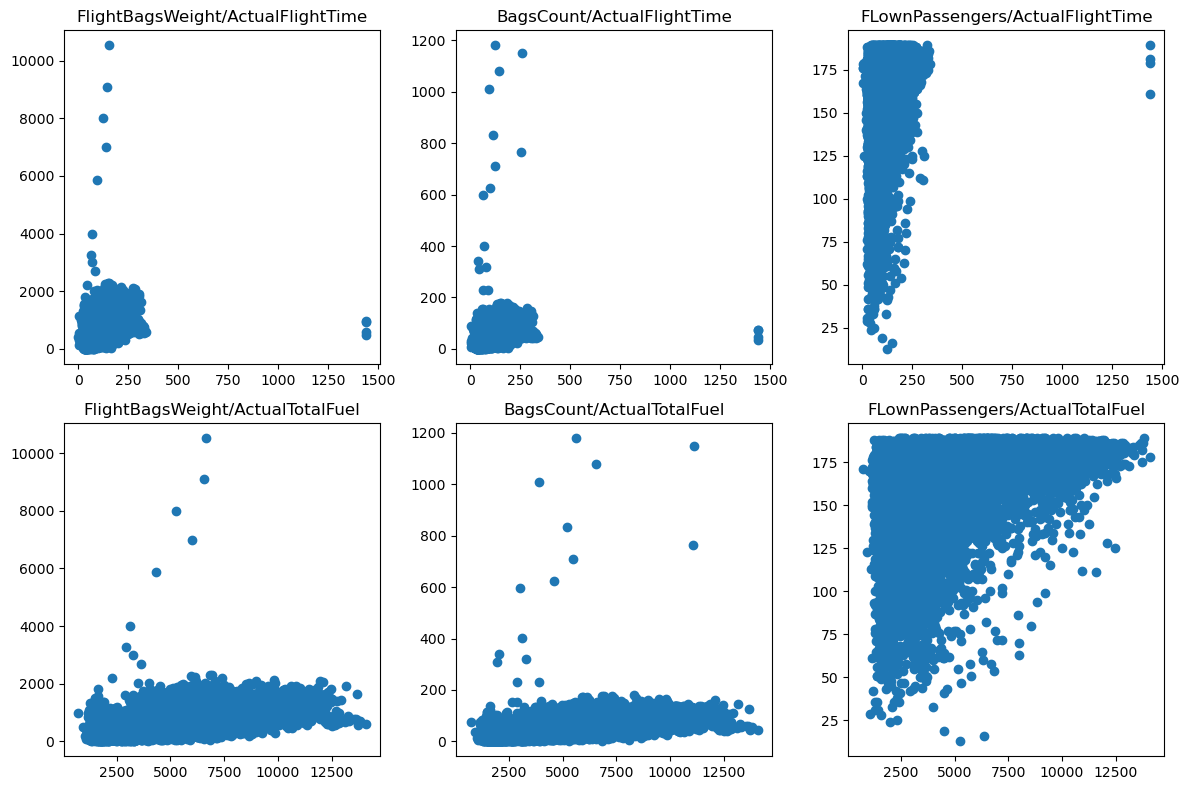

In [30]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Scatter plots
axes[0].scatter(df['ActualFlightTime'], df["FlightBagsWeight"])
axes[0].set_title("FlightBagsWeight/ActualFlightTime")

axes[3].scatter(df['ActualTotalFuel'], df["FlightBagsWeight"])
axes[3].set_title("FlightBagsWeight/ActualTotalFuel")

axes[1].scatter(df['ActualFlightTime'], df["BagsCount"])
axes[1].set_title("BagsCount/ActualFlightTime")

axes[4].scatter(df['ActualTotalFuel'], df["BagsCount"])
axes[4].set_title("BagsCount/ActualTotalFuel")

axes[2].scatter(df['ActualFlightTime'], df["FLownPassengers"])
axes[2].set_title("FLownPassengers/ActualFlightTime")

axes[5].scatter(df['ActualTotalFuel'], df["FLownPassengers"])
axes[5].set_title("FLownPassengers/ActualTotalFuel")

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

Most correlated value:

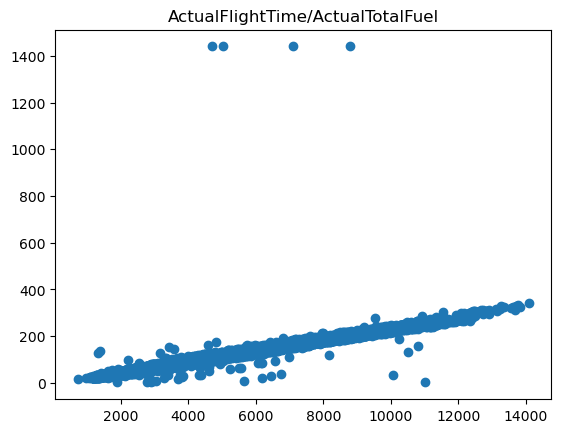

In [31]:
plt.scatter(df['ActualTotalFuel'], df["ActualFlightTime"])
plt.title("ActualFlightTime/ActualTotalFuel")

plt.show()

### Dealing with outliers:

Visual inspection:

In [32]:
bags_count = df.loc[df["BagsCount"] >= 200 ]
bags_weight = df.loc[df["FlightBagsWeight"] >= 2500 ]
flight_time = df.loc[df["ActualFlightTime"] >= 1000 ] 
flown_passengers = df.loc[df["FLownPassengers"] <= 20 ] 

outliers_indexes = flight_time.index.union(bags_weight.index).union(bags_count.index).union(flown_passengers.index)

test_df = df.drop(outliers_indexes)

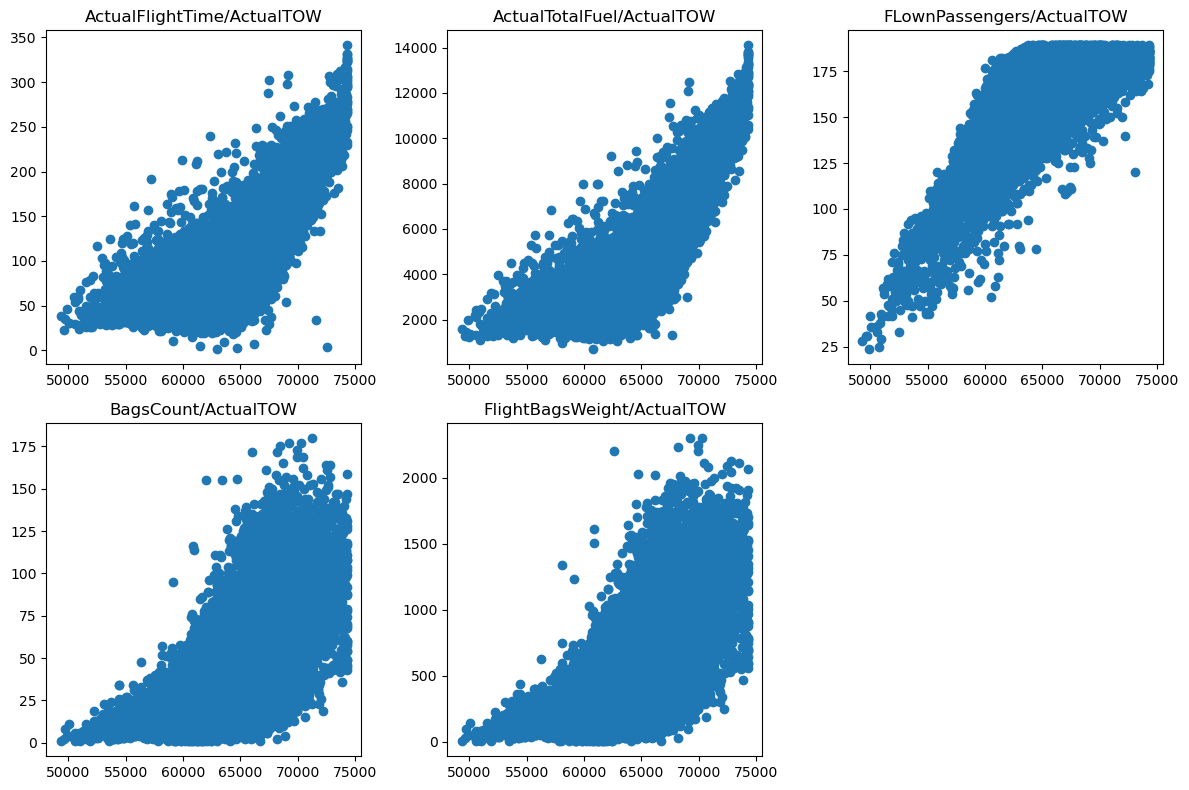

In [33]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Scatter plots
axes[0].scatter(test_df['ActualTOW'], test_df["ActualFlightTime"])
axes[0].set_title("ActualFlightTime/ActualTOW")

axes[1].scatter(test_df['ActualTOW'], test_df["ActualTotalFuel"])
axes[1].set_title("ActualTotalFuel/ActualTOW")

axes[2].scatter(test_df['ActualTOW'], test_df["FLownPassengers"])
axes[2].set_title("FLownPassengers/ActualTOW")

axes[3].scatter(test_df['ActualTOW'], test_df["BagsCount"])
axes[3].set_title("BagsCount/ActualTOW")

axes[4].scatter(test_df['ActualTOW'], test_df["FlightBagsWeight"])
axes[4].set_title("FlightBagsWeight/ActualTOW")

# Remove the 6th subplot
fig.delaxes(axes[5])

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

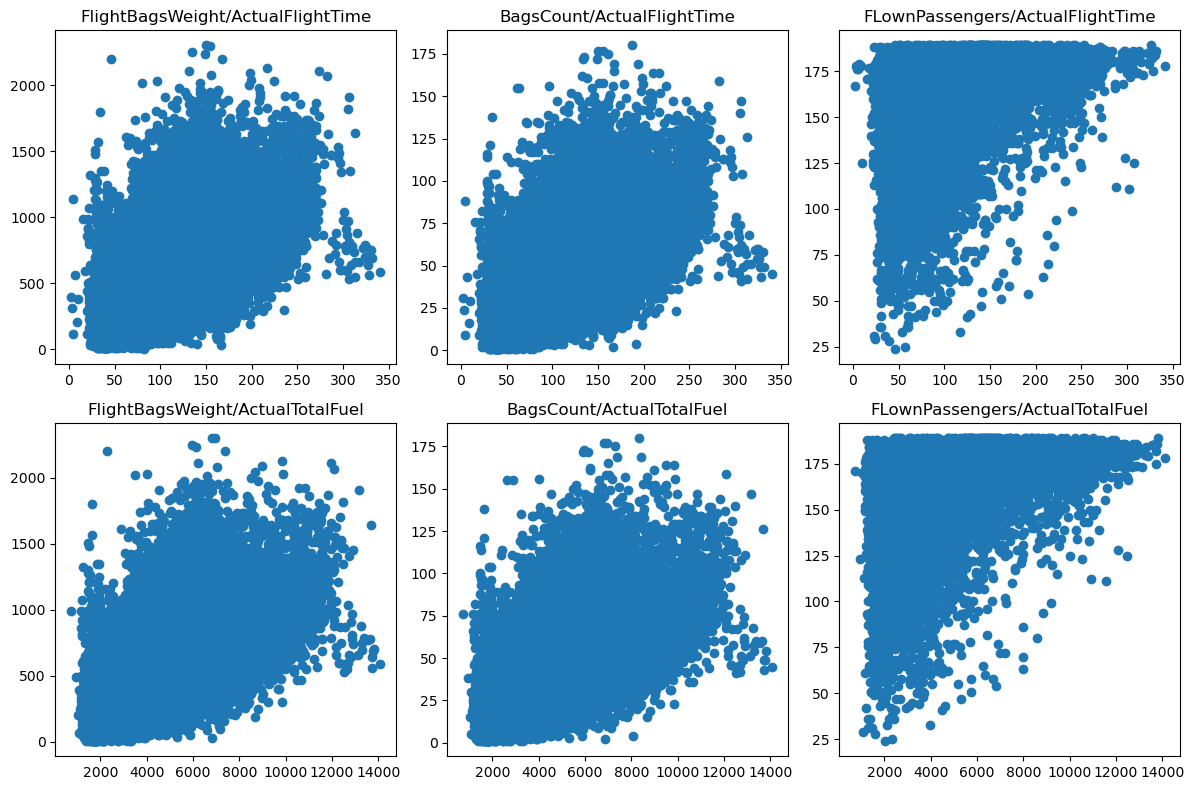

In [34]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Scatter plots
axes[0].scatter(test_df['ActualFlightTime'], test_df["FlightBagsWeight"])
axes[0].set_title("FlightBagsWeight/ActualFlightTime")

axes[3].scatter(test_df['ActualTotalFuel'], test_df["FlightBagsWeight"])
axes[3].set_title("FlightBagsWeight/ActualTotalFuel")

axes[1].scatter(test_df['ActualFlightTime'], test_df["BagsCount"])
axes[1].set_title("BagsCount/ActualFlightTime")

axes[4].scatter(test_df['ActualTotalFuel'], test_df["BagsCount"])
axes[4].set_title("BagsCount/ActualTotalFuel")

axes[2].scatter(test_df['ActualFlightTime'], test_df["FLownPassengers"])
axes[2].set_title("FLownPassengers/ActualFlightTime")

axes[5].scatter(test_df['ActualTotalFuel'], test_df["FLownPassengers"])
axes[5].set_title("FLownPassengers/ActualTotalFuel")

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

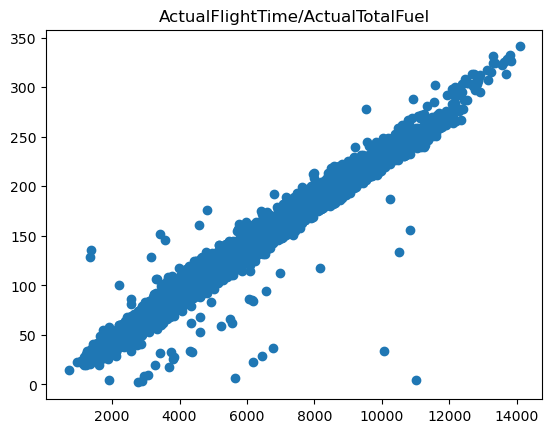

In [35]:
plt.scatter(test_df['ActualTotalFuel'], test_df["ActualFlightTime"])
plt.title("ActualFlightTime/ActualTotalFuel")

plt.show()

Interquartile Range (IQR) technique:

In [38]:
# Calculate the IQR for each feature
Q1 = X.quantile(0.25)
Q3 = X.quantile(0.75)
IQR = Q3 - Q1

# Identify outliers using the IQR method
outliers = ((X < (Q1 - 1.5 * IQR)) | (X > (Q3 + 1.5 * IQR))).any(axis=1)

# Filter the dataset to remove outliers
filtered_df = df[~outliers]

# Number of rows after removing outliers
num_rows_without_outliers = filtered_df.shape[0]

# Print the result
print("Number of rows after removing outliers:", num_rows_without_outliers)

Number of rows after removing outliers: 23679


Based on our main model output using XGBoost, we observed a smaller root mean squared error (RMSE) without applying any previous outlier handling techniques.

### Analyzing the Target (ActualTOW) variable

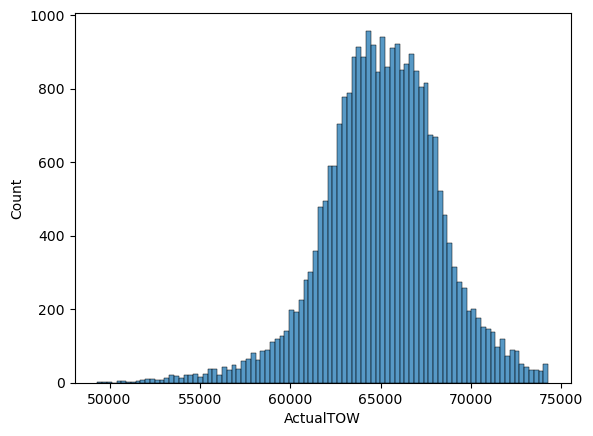

In [39]:
sns.histplot(df['ActualTOW'])
plt.show()

Boxplot for checking for any outliers or extreme values that may impact the model's performance.

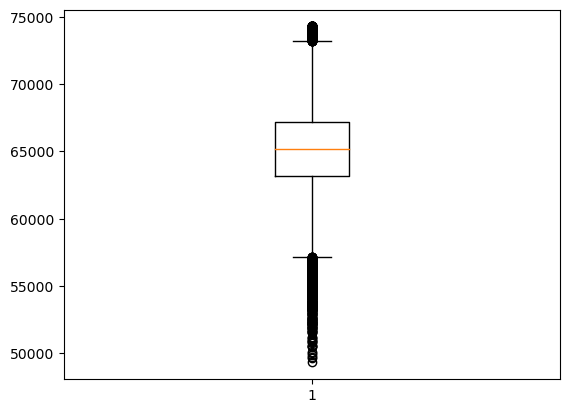

In [40]:
plt.boxplot(df['ActualTOW'])
plt.show()

In [41]:
df['ActualTOW'].describe()

count    26800.000000
mean     65084.024440
std       3235.481903
min      49322.000000
25%      63163.000000
50%      65158.000000
75%      67172.000000
max      74283.000000
Name: ActualTOW, dtype: float64

## Date-related Analysis

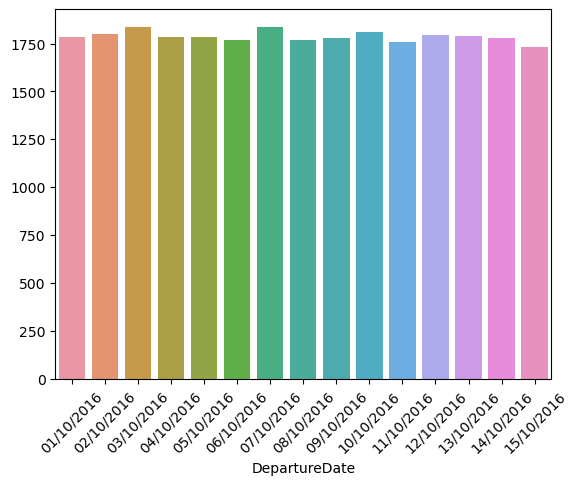

In [42]:
date_count = df.groupby(['DepartureDate']).size()
sns.barplot(x = date_count.index, y = date_count.values)
plt.xticks(rotation=45)
plt.show()

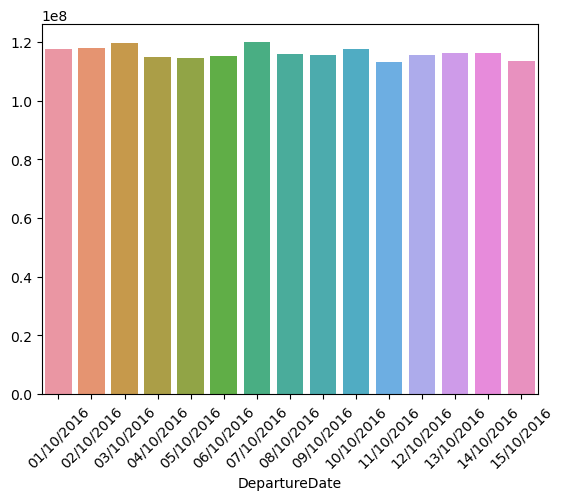

In [43]:
ActualTOW_by_date = df.groupby(['DepartureDate']).sum()["ActualTOW"]
sns.barplot(x = ActualTOW_by_date.index, y = ActualTOW_by_date.values)
plt.xticks(rotation=45)
plt.show()

Based on the above barplots, two key insights can be drawn. Firstly, there is an equal number of flights recorded every day. Secondly, certain weights remain consistent across multiple days. These observations suggest that we are not dealing with time-series data, and the variables in our dataset are not heavily influenced by the date.

# Airport Analysis

How many the same route we have:

In [44]:
route_count = df.groupby(['Route']).size()

In [45]:
route_count.describe()

count    2533.000000
mean       10.580340
std        11.349867
min         1.000000
25%         4.000000
50%         7.000000
75%        13.000000
max       117.000000
dtype: float64

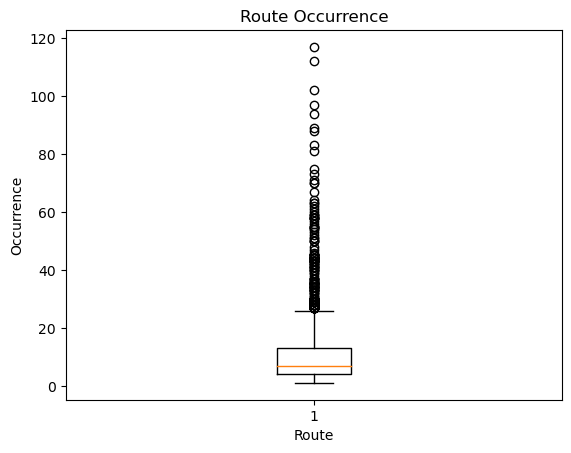

In [46]:
plt.boxplot(route_count)
plt.title("Route Occurrence")
plt.xlabel("Route")
plt.ylabel("Occurrence")
plt.show()

How mane the same airport we have:

In [47]:
unique_airports = pd.unique(df[['DepartureAirport', 'ArrivalAirport']].values.ravel())
print("Number of unique eirports in data:",len(unique_airports))

Number of unique eirports in data: 189


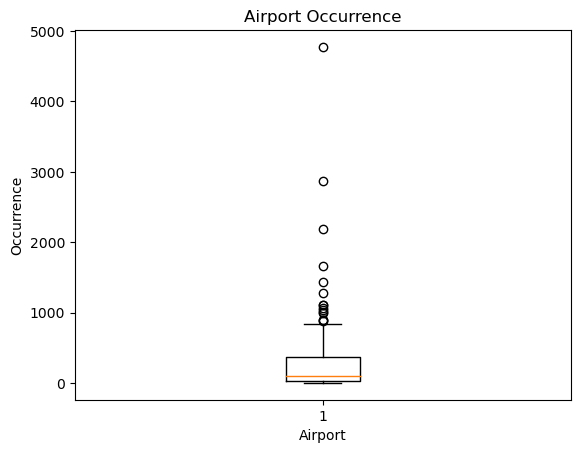

In [48]:
# Concatenate the 'DepartureAirport' and 'ArrivalAirport' columns to create a single column with all airports
all_airports = pd.concat([df['DepartureAirport'], df['ArrivalAirport']])

# Calculate the occurrence of each airport
airport_counts = all_airports.value_counts()

# Print the time each airport appears in the data
plt.boxplot(airport_counts)
# Set the title and labels
plt.title("Airport Occurrence")
plt.xlabel("Airport")
plt.ylabel("Occurrence")
plt.show()

In [63]:
airport_counts.describe()

count     189.000000
mean      283.597884
std       506.308204
min         3.000000
25%        30.000000
50%       101.000000
75%       367.000000
max      4774.000000
Name: count, dtype: float64

# Models fitting

In [72]:
X = df.drop(['DepartureDate', 'DepartureYear', 'DepartureMonth', 'DepartureDay', 
             'FlightNumber', 'DepartureAirport', 'ArrivalAirport', 'Route', 'ActualTOW'], axis = 1)
y = df['ActualTOW']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [50]:
def train_with_gs_and_test(model, param_grid, X_train, y_train, X_test, y_test):
    """
    Train a model using GridSearchCV and evaluate its performance on the test set.

    Parameters:
        model (estimator): Estimator object implementing 'fit' and 'predict' methods.
        param_grid (dict): Dictionary with parameters names (string) as keys and lists of parameter settings as values.
        X_train (array-like, shape (n_samples, n_features)): Training data.
        y_train (array-like, shape (n_samples,)): Target values for the training data.
        X_test (array-like, shape (n_samples, n_features)): Test data.
        y_test (array-like, shape (n_samples,)): Target values for the test data.

    Returns:
        None

    """
    # Create a pipeline with scaler and model
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])
    
    # Perform GridSearchCV to find the best model parameters
    CV_rfr = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=5, verbose=3, n_jobs=-1, scoring='neg_mean_squared_error')
    CV_rfr.fit(X_train, y_train)
    
    # Print the best parameters found during GridSearchCV
    print("Best parameters:", CV_rfr.best_params_)
    
    # Predict the target variable on the training set
    y_train_predict = CV_rfr.predict(X_train)
    
    # Calculate and print the root mean squared error (RMSE) on the training set
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_predict))
    print("\nModel performance for the training set:")
    print("--------------------------------------")
    print('RMSE:', rmse_train)
    
    # Predict the target variable on the test set
    y_pred = CV_rfr.predict(X_test)
    
    # Calculate and print the RMSE on the test set
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print("\nModel performance for the test set:")
    print("--------------------------------------")
    print("Root Mean Squared Error (RMSE):", rmse)
    print("\n")

# Linear Regression


In [ ]:
from sklearn.linear_model import LinearRegression

In [598]:
reg_all = LinearRegression()
grid = {
    
}

train_with_gs_and_test(reg_all, grid, X_train, y_train, X_test, y_test)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters: {}

Model performance for the training set:
--------------------------------------
RMSE: 1015.4563002254839

Model performance for the test set:
--------------------------------------
Root Mean Squared Error (RMSE): 1010.9343482106666




# Decision Tree

In [599]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree

In [600]:
DTR_regr = DecisionTreeRegressor()
grid = {
    "model__max_depth": [5, 10, 15, 20],
    "model__min_samples_leaf": [1, 5, 10, 15, 20],
    "model__ccp_alpha": [0,1,3,5] #Complexity parameter Pruning
}

train_with_gs_and_test(DTR_regr, grid, X_train, y_train, X_test, y_test)

Fitting 5 folds for each of 80 candidates, totalling 400 fits
Best parameters: {'model__ccp_alpha': 1, 'model__max_depth': 15, 'model__min_samples_leaf': 20}

Model performance for the training set:
--------------------------------------
RMSE: 874.2264620324939

Model performance for the test set:
--------------------------------------
Root Mean Squared Error (RMSE): 975.4967831949588




# Rnadom Forest Regression

In [198]:
from sklearn.ensemble import RandomForestRegressor

In [312]:
reg_rfr = RandomForestRegressor()
grid = {
    "model__n_estimators": [100, 300],
    #criterion is defult MSE
    "model__max_depth": [10, 20],
    "model__min_samples_leaf": [1, 3, 5, 20]
}

train_with_gs_and_test(reg_rfr, grid, X_train, y_train, X_test, y_test)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
{'model__max_depth': 20, 'model__min_samples_leaf': 5, 'model__n_estimators': 300}
model performance for training set
--------------------------------------
RMSE is 681.4172300095587

The Linear Regression performance for test set
--------------------------------------
Root Mean Squared Error: 902.3503315871495




In [94]:
feature_list = list(X.columns)
# Get numerical feature importances
importances = list(reg_rfr.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: ActualTotalFuel      Importance: 0.69
Variable: FLownPassengers      Importance: 0.28
Variable: ActualFlightTime     Importance: 0.02
Variable: FlightBagsWeight     Importance: 0.01
Variable: BagsCount            Importance: 0.0


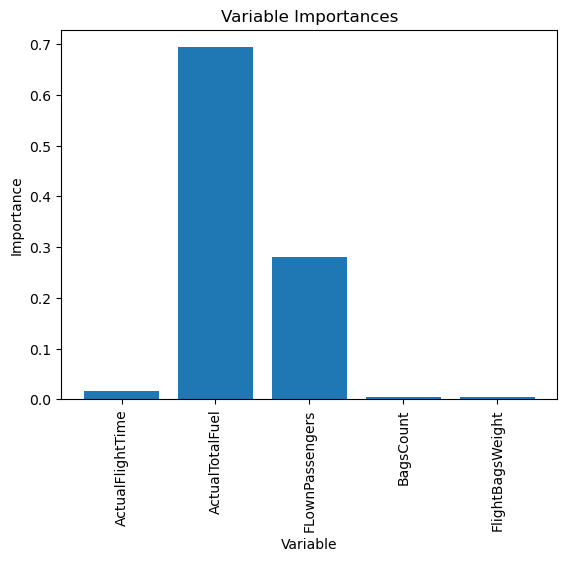

In [95]:
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

# Gradient Boosting Regressor

In [53]:
from sklearn.ensemble import GradientBoostingRegressor

In [55]:
GBR_regr = GradientBoostingRegressor()
grid = {
     "model__n_estimators": [100, 300],
    #criterion is defult MSE
    "model__max_depth": [10, 20],
    "model__min_samples_leaf": [1, 3, 5, 20]
}

train_with_gs_and_test(GBR_regr, grid, X_train, y_train, X_test, y_test)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters: {'model__max_depth': 10, 'model__min_samples_leaf': 20, 'model__n_estimators': 100}

Model performance for the training set:
--------------------------------------
RMSE: 719.820040274745

Model performance for the test set:
--------------------------------------
Root Mean Squared Error (RMSE): 898.7343892859649


[CV 1/5] END model__max_depth=10, model__min_samples_leaf=1, model__n_estimators=100;, score=-950252.648 total time=   4.2s
[CV 3/5] END model__max_depth=10, model__min_samples_leaf=3, model__n_estimators=100;, score=-946558.005 total time=   4.0s
[CV 1/5] END model__max_depth=10, model__min_samples_leaf=3, model__n_estimators=300;, score=-962679.465 total time=  13.2s
[CV 3/5] END model__max_depth=10, model__min_samples_leaf=5, model__n_estimators=300;, score=-950899.648 total time=  12.4s
[CV 5/5] END model__max_depth=10, model__min_samples_leaf=20, model__n_estimators=300;, score=-830826.598 total

[CV 1/5] END ............................., score=-980556.193 total time=   1.2s
[CV 2/5] END model__max_depth=10, model__min_samples_leaf=1, model__n_estimators=100;, score=-888540.476 total time=   4.3s
[CV 4/5] END model__max_depth=10, model__min_samples_leaf=1, model__n_estimators=300;, score=-911903.386 total time=  12.4s
[CV 3/5] END model__max_depth=10, model__min_samples_leaf=5, model__n_estimators=100;, score=-932838.608 total time=   4.8s
[CV 5/5] END model__max_depth=10, model__min_samples_leaf=5, model__n_estimators=100;, score=-860082.658 total time=   4.3s
[CV 4/5] END model__max_depth=10, model__min_samples_leaf=5, model__n_estimators=300;, score=-877917.877 total time=  12.9s
[CV 3/5] END model__max_depth=20, model__min_samples_leaf=1, model__n_estimators=100;, score=-1497796.476 total time=   8.8s
[CV 5/5] END model__max_depth=20, model__min_samples_leaf=1, model__n_estimators=300;, score=-1421298.327 total time=  25.6s
[CV 5/5] END model__max_depth=20, model__min_samp

# XGBoost

In [299]:
import xgboost as xgb
from sklearn import metrics

In [73]:
model_XGBoost = xgb.XGBRegressor()
grid = {
    "model__n_estimators": [1000],
    "model__max_depth": [5],
    "model__max_leaves": [1],
    "model__learning_rate": [ 0.03]
}

train_with_gs_and_test(model_XGBoost, grid, X_train, y_train, X_test, y_test)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters: {'model__learning_rate': 0.03, 'model__max_depth': 5, 'model__max_leaves': 1, 'model__n_estimators': 1000}

Model performance for the training set:
--------------------------------------
RMSE: 781.75186145926

Model performance for the test set:
--------------------------------------
Root Mean Squared Error (RMSE): 880.8006614025403


[CV 2/5] END model__learning_rate=0.03, model__max_depth=5, model__max_leaves=1, model__n_estimators=1000;, score=nan total time=   0.0s
[CV 5/5] END model__learning_rate=0.03, model__max_depth=5, model__max_leaves=1, model__n_estimators=1000;, score=-69081677.534 total time=   6.7s
[CV 5/5] END model__learning_rate=0.03, model__max_depth=5, model__max_leaves=1, model__n_estimators=1000;, score=nan total time=   0.0s
[CV 4/5] END model__learning_rate=0.03, model__max_depth=5, model__max_leaves=1, model__n_estimators=1000;, score=-60302071.201 total time=   6.9s
[CV 1/5] END model_

In [469]:
model_XGBoost = xgb.XGBRegressor()
grid = {
    "model__n_estimators": [300, 500, 1000],
    "model__max_depth": [5, 10, 20],
    "model__max_leaves": [1, 3, 5, 20],
    "model__learning_rate": [0.01, 0.03, 0.07] #prevents overfitting make the boosting process more conservative.
}

train_with_gs_and_test(model_XGBoost, grid, X_train, y_train, X_test, y_test)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV 3/5] END model__learning_rate=0.03, model__max_depth=5, model__max_leaves=1, model__n_estimators=1000;, score=-845667.367 total time=   6.1s
[CV 1/5] END model__learning_rate=0.01, model__max_depth=5, model__max_leaves=1, model__n_estimators=300;, score=-11398026.772 total time=   2.3s
[CV 3/5] END model__learning_rate=0.01, model__max_depth=5, model__max_leaves=1, model__n_estimators=1000;, score=-898937.675 total time=   7.7s
[CV 5/5] END model__learning_rate=0.01, model__max_depth=5, model__max_leaves=3, model__n_estimators=500;, score=-1088142.137 total time=   3.8s
[CV 3/5] END model__learning_rate=0.01, model__max_depth=5, model__max_leaves=5, model__n_estimators=300;, score=-11637496.623 total time=   2.2s
[CV 1/5] END model__learning_rate=0.01, model__max_depth=5, model__max_leaves=5, model__n_estimators=500;, score=-1183116.351 total time=   3.9s
[CV 4/5] END model__learning_rate=0.01, model__max_depth=5, model

/Users/romafurman/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 4/5] END model__learning_rate=0.03, model__max_depth=5, model__max_leaves=1, model__n_estimators=1000;, score=-798619.529 total time=   6.1s
[CV 3/5] END model__learning_rate=0.03, model__max_depth=5, model__max_leaves=1, model__n_estimators=1000;, score=-845404.823 total time=   6.2s
[CV 3/5] END model__learning_rate=0.01, model__max_depth=5, model__max_leaves=1, model__n_estimators=500;, score=-1213893.032 total time=   3.8s
[CV 1/5] END model__learning_rate=0.01, model__max_depth=5, model__max_leaves=3, model__n_estimators=300;, score=-11398026.772 total time=   2.2s
[CV 3/5] END model__learning_rate=0.01, model__max_depth=5, model__max_leaves=3, model__n_estimators=300;, score=-11637496.623 total time=   2.2s
[CV 1/5] END model__learning_rate=0.01, model__max_depth=5, model__max_leaves=3, model__n_estimators=500;, score=-1183116.351 total time=   4.0s
[CV 5/5] END model__learning_rate=0.01, model__max_depth=5, model__max_leaves=3, model__n_estimators=1000;, score=-830482.790 to

[CV 5/5] END model__learning_rate=0.03, model__max_depth=5, model__max_leaves=1, model__n_estimators=1000;, score=-791248.962 total time=   6.2s
[CV 4/5] END model__learning_rate=0.01, model__max_depth=5, model__max_leaves=1, model__n_estimators=300;, score=-11310510.591 total time=   2.3s
[CV 5/5] END model__learning_rate=0.01, model__max_depth=5, model__max_leaves=1, model__n_estimators=500;, score=-1088142.137 total time=   3.8s
[CV 2/5] END model__learning_rate=0.01, model__max_depth=5, model__max_leaves=3, model__n_estimators=300;, score=-11154347.284 total time=   2.2s
[CV 5/5] END model__learning_rate=0.01, model__max_depth=5, model__max_leaves=3, model__n_estimators=300;, score=-11087954.732 total time=   2.4s
[CV 1/5] END model__learning_rate=0.01, model__max_depth=5, model__max_leaves=3, model__n_estimators=1000;, score=-893052.102 total time=   7.4s
[CV 3/5] END model__learning_rate=0.01, model__max_depth=5, model__max_leaves=5, model__n_estimators=500;, score=-1213893.032 t

[CV 2/5] END model__learning_rate=0.03, model__max_depth=5, model__max_leaves=1, model__n_estimators=1000;, score=-801204.800 total time=   6.1s
[CV 2/5] END model__learning_rate=0.01, model__max_depth=5, model__max_leaves=1, model__n_estimators=500;, score=-1100655.512 total time=   3.9s
[CV 4/5] END model__learning_rate=0.01, model__max_depth=5, model__max_leaves=1, model__n_estimators=1000;, score=-830601.137 total time=   7.5s
[CV 2/5] END model__learning_rate=0.01, model__max_depth=5, model__max_leaves=3, model__n_estimators=1000;, score=-837315.186 total time=   7.6s
[CV 5/5] END model__learning_rate=0.01, model__max_depth=5, model__max_leaves=5, model__n_estimators=500;, score=-1088142.137 total time=   3.8s
[CV 3/5] END model__learning_rate=0.01, model__max_depth=5, model__max_leaves=20, model__n_estimators=300;, score=-11637496.623 total time=   2.4s
[CV 1/5] END model__learning_rate=0.01, model__max_depth=5, model__max_leaves=20, model__n_estimators=500;, score=-1183116.351 t

[CV 4/5] END model__learning_rate=0.01, model__max_depth=20, model__max_leaves=5, model__n_estimators=300;, score=-11283270.982 total time=   3.3s
[CV 2/5] END model__learning_rate=0.01, model__max_depth=20, model__max_leaves=5, model__n_estimators=500;, score=-1062464.596 total time=  11.4s
[CV 5/5] END model__learning_rate=0.01, model__max_depth=20, model__max_leaves=5, model__n_estimators=500;, score=-1043469.540 total time=  12.2s
[CV 4/5] END model__learning_rate=0.01, model__max_depth=20, model__max_leaves=5, model__n_estimators=1000;, score=-884068.868 total time=  36.8s
[CV 2/5] END model__learning_rate=0.03, model__max_depth=5, model__max_leaves=1, model__n_estimators=300;, score=-847204.188 total time=   2.3s
[CV 5/5] END model__learning_rate=0.03, model__max_depth=5, model__max_leaves=1, model__n_estimators=300;, score=-844363.557 total time=   2.4s
[CV 3/5] END model__learning_rate=0.03, model__max_depth=5, model__max_leaves=1, model__n_estimators=500;, score=-865685.239 to

[CV 4/5] END model__learning_rate=0.03, model__max_depth=5, model__max_leaves=5, model__n_estimators=300;, score=-839813.767 total time=   2.3s
[CV 4/5] END model__learning_rate=0.03, model__max_depth=5, model__max_leaves=5, model__n_estimators=500;, score=-807833.523 total time=   3.9s
[CV 2/5] END model__learning_rate=0.03, model__max_depth=5, model__max_leaves=20, model__n_estimators=300;, score=-847204.188 total time=   2.3s
[CV 5/5] END model__learning_rate=0.03, model__max_depth=5, model__max_leaves=20, model__n_estimators=300;, score=-844363.557 total time=   2.3s
[CV 3/5] END model__learning_rate=0.03, model__max_depth=5, model__max_leaves=20, model__n_estimators=500;, score=-865685.239 total time=   3.8s
[CV 1/5] END model__learning_rate=0.03, model__max_depth=10, model__max_leaves=1, model__n_estimators=300;, score=-856435.047 total time=   4.6s
[CV 4/5] END model__learning_rate=0.03, model__max_depth=10, model__max_leaves=1, model__n_estimators=300;, score=-802362.816 total 

[CV 1/5] END model__learning_rate=0.03, model__max_depth=5, model__max_leaves=1, model__n_estimators=300;, score=-908832.108 total time=   2.5s
[CV 4/5] END model__learning_rate=0.03, model__max_depth=5, model__max_leaves=1, model__n_estimators=300;, score=-839813.767 total time=   2.4s
[CV 2/5] END model__learning_rate=0.03, model__max_depth=5, model__max_leaves=1, model__n_estimators=500;, score=-814119.424 total time=   4.1s
[CV 5/5] END model__learning_rate=0.03, model__max_depth=5, model__max_leaves=1, model__n_estimators=500;, score=-802158.885 total time=   3.9s
[CV 3/5] END model__learning_rate=0.03, model__max_depth=5, model__max_leaves=1, model__n_estimators=1000;, score=-845667.367 total time=   8.0s
[CV 1/5] END model__learning_rate=0.03, model__max_depth=5, model__max_leaves=3, model__n_estimators=300;, score=-908832.108 total time=   2.6s
[CV 3/5] END model__learning_rate=0.03, model__max_depth=5, model__max_leaves=3, model__n_estimators=300;, score=-909793.302 total time

[CV 5/5] END model__learning_rate=0.03, model__max_depth=20, model__max_leaves=1, model__n_estimators=1000;, score=-910979.267 total time=  41.2s
[CV 3/5] END model__learning_rate=0.03, model__max_depth=20, model__max_leaves=3, model__n_estimators=1000;, score=-961970.422 total time=  56.4s
[CV 1/5] END model__learning_rate=0.03, model__max_depth=20, model__max_leaves=20, model__n_estimators=300;, score=-924293.686 total time=  22.0s
[CV 4/5] END model__learning_rate=0.03, model__max_depth=20, model__max_leaves=20, model__n_estimators=300;, score=-876963.751 total time=  12.1s
[CV 2/5] END model__learning_rate=0.03, model__max_depth=20, model__max_leaves=20, model__n_estimators=500;, score=-922430.860 total time=  53.3s
[CV 2/5] END model__learning_rate=0.07, model__max_depth=5, model__max_leaves=1, model__n_estimators=300;, score=-805270.035 total time=   3.0s
[CV 4/5] END model__learning_rate=0.07, model__max_depth=5, model__max_leaves=1, model__n_estimators=300;, score=-798687.514 t

[CV 4/5] END model__learning_rate=0.03, model__max_depth=20, model__max_leaves=3, model__n_estimators=500;, score=-899693.563 total time=  20.3s
[CV 2/5] END model__learning_rate=0.03, model__max_depth=20, model__max_leaves=5, model__n_estimators=300;, score=-896036.835 total time=  10.8s
[CV 5/5] END model__learning_rate=0.03, model__max_depth=20, model__max_leaves=5, model__n_estimators=300;, score=-872696.859 total time=  10.5s
[CV 3/5] END model__learning_rate=0.03, model__max_depth=20, model__max_leaves=5, model__n_estimators=500;, score=-949869.449 total time=  22.6s
[CV 2/5] END model__learning_rate=0.03, model__max_depth=20, model__max_leaves=5, model__n_estimators=1000;, score=-938974.911 total time=  52.6s
[CV 4/5] END model__learning_rate=0.03, model__max_depth=20, model__max_leaves=20, model__n_estimators=500;, score=-899693.563 total time=  36.6s
[CV 5/5] END model__learning_rate=0.03, model__max_depth=20, model__max_leaves=20, model__n_estimators=1000;, score=-910979.267 

In [332]:
from sklearn.feature_selection import RFECV
# we work with wrapper method thats why i choose recirsive feature elimination
fs = RFECV(xgb.XGBRegressor(), cv=3)
fs.fit(X_train, y_train)
fs.feature_names_in_

array(['ActualFlightTime', 'ActualTotalFuel', 'FLownPassengers',
       'BagsCount', 'FlightBagsWeight'], dtype=object)

In [420]:
feature_list = list(X.columns)
# Get numerical feature importances
importances = list(model.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: ActualTotalFuel      Importance: 0.6299999952316284
Variable: FLownPassengers      Importance: 0.3199999928474426
Variable: ActualFlightTime     Importance: 0.019999999552965164
Variable: FlightBagsWeight     Importance: 0.019999999552965164
Variable: BagsCount            Importance: 0.009999999776482582


# Support vector Machine - SVR

In [313]:
from sklearn import svm

In [58]:
model_svr = svm.SVR()
grid = {
       }


train_with_gs_and_test(model_svr, grid, X_train, y_train, X_test, y_test)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters: {}

Model performance for the training set:
--------------------------------------
RMSE: 2327.8013999467594

Model performance for the test set:
--------------------------------------
Root Mean Squared Error (RMSE): 2325.8211502271793


[CV 5/5] END ............................, score=-6089229.554 total time=  31.8s
[CV 2/5] END ............................, score=-5451157.709 total time=  31.8s
[CV 1/5] END ............................, score=-5801846.631 total time=  32.1s
[CV 3/5] END ............................, score=-5986319.764 total time=  32.1s
[CV 4/5] END ............................, score=-5969222.278 total time=  32.4s


In [64]:
model_svr = svm.SVR()
grid = {'model__kernel' : ('linear',), # Specifies the kernel type to be used in the algorithm
        'model__C' : [1,5,10,100]
        #'model__degree' : [3,8], # Degree of the polynomial kernel function (‘poly’)
        #'model__coef0' : [0.01,10,0.5], #independent coef It is only significant in ‘poly’ and ‘sigmoid’.
        #'model__gamma' : [0.001, 0.0001] #Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’.
       }


train_with_gs_and_test(model_svr, grid, X_train, y_train, X_test, y_test)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters: {'model__C': 5, 'model__kernel': 'linear'}

Model performance for the training set:
--------------------------------------
RMSE: 1041.8437817678814

Model performance for the test set:
--------------------------------------
Root Mean Squared Error (RMSE): 1038.5293398978558


[CV 1/5] END model__C=1, model__kernel=linear;, score=-1180815.274 total time=  21.6s
[CV 4/5] END model__C=10, model__kernel=linear;, score=-1099729.772 total time=  24.2s
[CV 3/5] END model__C=5, model__kernel=linear;, score=-1166266.209 total time=  21.5s
[CV 2/5] END model__C=10, model__kernel=linear;, score=-1042719.756 total time=  24.4s
[CV 2/5] END model__C=5, model__kernel=linear;, score=-1085964.851 total time=  21.6s
[CV 5/5] END model__C=10, model__kernel=linear;, score=-1179695.566 total time=  24.5s
[CV 4/5] END model__C=1, model__kernel=linear;, score=-1150401.979 total time=  21.7s
[CV 1/5] END model__C=100, model__kernel=

# Multilayer Perseptrone

In [324]:
from sklearn.neural_network import MLPRegressor

In [608]:
regr_MLPR = MLPRegressor()
grid = {"model__hidden_layer_sizes": [(256,128),(10,100)],
        "model__activation": ["relu"],
        "model__solver": ["adam"],
        "model__max_iter": [200,300,500],
        "model__alpha": [0.0001]# the same as defoult
       }


train_with_gs_and_test(regr_MLPR, grid, X_train, y_train, X_test, y_test)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


/Users/romafurman/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/romafurman/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/romafurman/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/romafurman/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

[CV 1/5] END model__activation=relu, model__alpha=0.0001, model__hidden_layer_sizes=(256, 128), model__max_iter=300, model__solver=adam;, score=-958527.628 total time=  56.2s
[CV 5/5] END model__activation=relu, model__alpha=0.0001, model__hidden_layer_sizes=(256, 128), model__max_iter=500, model__solver=adam;, score=-905291.930 total time=  49.3s
[CV 4/5] END model__activation=relu, model__alpha=0.0001, model__hidden_layer_sizes=(10, 100), model__max_iter=300, model__solver=adam;, score=-941295.991 total time=  14.5s
[CV 4/5] END model__activation=relu, model__alpha=0.0001, model__hidden_layer_sizes=(256, 128), model__max_iter=200, model__solver=adam;, score=-957822.051 total time=  55.7s
[CV 4/5] END model__activation=relu, model__alpha=0.0001, model__hidden_layer_sizes=(256, 128), model__max_iter=500, model__solver=adam;, score=-955904.325 total time=  49.7s
[CV 3/5] END model__activation=relu, model__alpha=0.0001, model__hidden_layer_sizes=(10, 100), model__max_iter=300, model__sol

## Models RMSE:

In [57]:
print("Liniar regression models' RMSE:", 1010.93)
print("Decision tree models' RMSE:", 975.49)
print("Random forest models' RMSE:", 902.35)
print("Gradient Boosting Regressor", 898.73)
print("XGBoost models' RMSE:", 880.80)
print("Support Vector Regressor models' RMSE:", 1038.53)
print("Multi-layer perceptron models' RMSE:", 1032.80)

Liniar regression models' RMSE: 1010.93
Decision tree models' RMSE: 975.49
Random forest models' RMSE: 902.35
Gradient Boosting Regressor 898.73
XGBoost models' RMSE: 880.8
Support Vector Regressor models' RMSE: 1038.53
Multi-layer perceptron models' RMSE: 1032.8


# Best model:

XGBRegressor

In [611]:
df_validation = pd.read_csv("validation.csv", sep='\s+')

In [613]:
print(f"Number of rows: {len(df_validation)}")
print(f"Colums: {[column for column in df_validation.columns]}")

Number of rows: 1878
Colums: ['DepartureDate', 'DepartureYear', 'DepartureMonth', 'DepartureDay', 'FlightNumber', 'DepartureAirport', 'ArrivalAirport', 'Route', 'ActualFlightTime', 'ActualTotalFuel', 'FLownPassengers', 'BagsCount', 'FlightBagsWeight']


In [614]:
df_validation = df_validation.replace("(null)",np.nan)
missing_df = df_validation.isnull().sum(axis=0).reset_index()
missing_df.columns = ['variable', 'missing values']
missing_df['filling factor (%)']=(df.shape[0]-missing_df['missing values'])/df_validation.shape[0]*100
missing_df.sort_values('filling factor (%)').reset_index(drop = True)

,variable,missing values,filling factor (%)
0,FlightBagsWeight,181,1417.412141
1,BagsCount,168,1418.104366
2,FLownPassengers,9,1426.570820
3,DepartureDate,0,1427.050053
4,DepartureYear,0,1427.050053
5,DepartureMonth,0,1427.050053
6,DepartureDay,0,1427.050053
7,FlightNumber,0,1427.050053
8,DepartureAirport,0,1427.050053
9,ArrivalAirport,0,1427.050053


In [617]:
numerical_columns = ['DepartureYear', 'DepartureMonth', 'DepartureDay', 'FlightNumber', 'ActualFlightTime', 
                     'ActualTotalFuel', 'FLownPassengers', 'BagsCount', 'FlightBagsWeight']

for column in numerical_columns:
    df_validation[column] = pd.to_numeric(df_validation[column])

In [620]:
df_validation.head(3)

,DepartureDate,DepartureYear,DepartureMonth,DepartureDay,FlightNumber,DepartureAirport,ArrivalAirport,Route,ActualFlightTime,ActualTotalFuel,FLownPassengers,BagsCount,FlightBagsWeight
0,01/11/2016,2016,11,1,6003,MRS,BES,MRS-BES,84,3630,185.0,43.0,560.0
1,01/11/2016,2016,11,1,6004,BES,MRS,BES-MRS,86,3690,188.0,NaN,NaN
2,01/11/2016,2016,11,1,6542,MRS,STN,MRS-STN,100,4390,168.0,55.0,720.0


In [624]:
X = df.drop(['DepartureDate', 'DepartureYear', 'DepartureMonth', 'DepartureDay', 
             'FlightNumber', 'DepartureAirport', 'ArrivalAirport', 'Route', 'ActualTOW'], axis = 1)
y = df['ActualTOW']

X_validation = df_validation.drop(['DepartureDate', 'DepartureYear', 'DepartureMonth', 'DepartureDay', 
             'FlightNumber', 'DepartureAirport', 'ArrivalAirport', 'Route'], axis = 1)

In [619]:
def train_with_gs_and_test(model, param_grid, X_train, y_train):
    """
    Train a model using GridSearchCV and evaluate its performance on the test set.

    Parameters:
        model (estimator): Estimator object implementing 'fit' and 'predict' methods.
        param_grid (dict): Dictionary with parameters names (string) as keys and lists of parameter settings as values.
        X_train (array-like, shape (n_samples, n_features)): Training data.
        y_train (array-like, shape (n_samples,)): Target values for the training data.

    Returns:
        None

    """
    # Create a pipeline with scaler and model
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])
    
    # Perform GridSearchCV to find the best model parameters
    CV_rfr = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=5, verbose=3, n_jobs=-1, scoring='neg_mean_squared_error')
    CV_rfr.fit(X_train, y_train)
    
    # Print the best parameters found during GridSearchCV
    print("Best parameters:", CV_rfr.best_params_)
    
    # Predict the target variable on the training set
    y_train_predict = CV_rfr.predict(X_train)
    
    # Calculate and print the root mean squared error (RMSE) on the training set
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_predict))
    print("\nModel performance for the training set:")
    print("--------------------------------------")
    print('RMSE:', rmse_train)

In [630]:
model_XGBoost = xgb.XGBRegressor()
grid = {
    "model__n_estimators": [300, 500, 1000],
    "model__max_depth": [5, 10, 20],
    "model__max_leaves": [1, 3, 5, 20],
    "model__learning_rate": [0.01, 0.03, 0.07]
}

train_with_gs_and_test(model_XGBoost, grid, X, y)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV 5/5] END model__learning_rate=0.01, model__max_depth=5, model__max_leaves=1, model__n_estimators=300;, score=-11419407.713 total time=   2.9s
[CV 5/5] END model__learning_rate=0.01, model__max_depth=5, model__max_leaves=1, model__n_estimators=500;, score=-1195527.436 total time=   4.9s
[CV 3/5] END model__learning_rate=0.01, model__max_depth=5, model__max_leaves=3, model__n_estimators=300;, score=-11035509.980 total time=   2.9s
[CV 1/5] END model__learning_rate=0.01, model__max_depth=5, model__max_leaves=3, model__n_estimators=500;, score=-1248036.665 total time=   5.1s
[CV 4/5] END model__learning_rate=0.01, model__max_depth=5, model__max_leaves=3, model__n_estimators=1000;, score=-859324.908 total time=   9.8s
[CV 2/5] END model__learning_rate=0.01, model__max_depth=5, model__max_leaves=5, model__n_estimators=1000;, score=-888372.324 total time=  10.7s
[CV 5/5] END model__learning_rate=0.01, model__max_depth=5, model

/Users/romafurman/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 1/5] END model__learning_rate=0.01, model__max_depth=5, model__max_leaves=1, model__n_estimators=500;, score=-1248036.665 total time=   4.9s
[CV 4/5] END model__learning_rate=0.01, model__max_depth=5, model__max_leaves=1, model__n_estimators=1000;, score=-859324.908 total time=   9.9s
[CV 3/5] END model__learning_rate=0.01, model__max_depth=5, model__max_leaves=3, model__n_estimators=1000;, score=-772510.090 total time=   9.9s
[CV 1/5] END model__learning_rate=0.01, model__max_depth=5, model__max_leaves=5, model__n_estimators=1000;, score=-828941.959 total time=  10.5s
[CV 2/5] END model__learning_rate=0.01, model__max_depth=5, model__max_leaves=20, model__n_estimators=500;, score=-1115531.961 total time=   5.4s
[CV 5/5] END model__learning_rate=0.01, model__max_depth=5, model__max_leaves=20, model__n_estimators=1000;, score=-912814.272 total time=  10.7s
[CV 3/5] END model__learning_rate=0.01, model__max_depth=10, model__max_leaves=1, model__n_estimators=1000;, score=-747379.564 t

[CV 1/5] END model__learning_rate=0.01, model__max_depth=5, model__max_leaves=1, model__n_estimators=300;, score=-12505376.817 total time=   3.0s
[CV 3/5] END model__learning_rate=0.01, model__max_depth=5, model__max_leaves=1, model__n_estimators=1000;, score=-772510.090 total time=   9.8s
[CV 5/5] END model__learning_rate=0.01, model__max_depth=5, model__max_leaves=3, model__n_estimators=500;, score=-1195527.436 total time=   5.0s
[CV 3/5] END model__learning_rate=0.01, model__max_depth=5, model__max_leaves=5, model__n_estimators=300;, score=-11035509.980 total time=   3.0s
[CV 1/5] END model__learning_rate=0.01, model__max_depth=5, model__max_leaves=5, model__n_estimators=500;, score=-1248036.665 total time=   5.1s
[CV 4/5] END model__learning_rate=0.01, model__max_depth=5, model__max_leaves=5, model__n_estimators=1000;, score=-859324.908 total time=  10.6s
[CV 2/5] END model__learning_rate=0.01, model__max_depth=5, model__max_leaves=20, model__n_estimators=1000;, score=-888372.324 t

[CV 4/5] END model__learning_rate=0.01, model__max_depth=20, model__max_leaves=3, model__n_estimators=1000;, score=-918943.332 total time=  49.1s
[CV 2/5] END model__learning_rate=0.01, model__max_depth=20, model__max_leaves=20, model__n_estimators=300;, score=-10638588.352 total time=   4.6s
[CV 5/5] END model__learning_rate=0.01, model__max_depth=20, model__max_leaves=20, model__n_estimators=300;, score=-11363672.717 total time=   4.5s
[CV 3/5] END model__learning_rate=0.01, model__max_depth=20, model__max_leaves=20, model__n_estimators=500;, score=-974286.242 total time=  15.3s
[CV 1/5] END model__learning_rate=0.01, model__max_depth=20, model__max_leaves=20, model__n_estimators=1000;, score=-886415.756 total time=  46.8s
[CV 4/5] END model__learning_rate=0.01, model__max_depth=20, model__max_leaves=20, model__n_estimators=300;, score=-10869023.042 total time=   4.5s
[CV 2/5] END model__learning_rate=0.01, model__max_depth=20, model__max_leaves=20, model__n_estimators=500;, score=-1

[CV 3/5] END model__learning_rate=0.03, model__max_depth=5, model__max_leaves=1, model__n_estimators=300;, score=-779193.959 total time=   3.1s
[CV 1/5] END model__learning_rate=0.03, model__max_depth=5, model__max_leaves=1, model__n_estimators=500;, score=-796709.978 total time=   5.2s
[CV 4/5] END model__learning_rate=0.03, model__max_depth=5, model__max_leaves=1, model__n_estimators=500;, score=-834928.072 total time=   5.0s
[CV 2/5] END model__learning_rate=0.03, model__max_depth=5, model__max_leaves=1, model__n_estimators=1000;, score=-844302.670 total time=  10.4s
[CV 5/5] END model__learning_rate=0.03, model__max_depth=5, model__max_leaves=1, model__n_estimators=1000;, score=-869416.035 total time=  10.3s
[CV 3/5] END model__learning_rate=0.03, model__max_depth=5, model__max_leaves=3, model__n_estimators=500;, score=-744852.992 total time=   5.5s
[CV 4/5] END model__learning_rate=0.03, model__max_depth=5, model__max_leaves=3, model__n_estimators=1000;, score=-827110.662 total ti

[CV 3/5] END model__learning_rate=0.03, model__max_depth=5, model__max_leaves=5, model__n_estimators=300;, score=-779193.959 total time=   3.0s
[CV 2/5] END model__learning_rate=0.03, model__max_depth=5, model__max_leaves=5, model__n_estimators=500;, score=-855723.726 total time=   5.1s
[CV 5/5] END model__learning_rate=0.03, model__max_depth=5, model__max_leaves=5, model__n_estimators=1000;, score=-869416.035 total time=  10.1s
[CV 4/5] END model__learning_rate=0.03, model__max_depth=5, model__max_leaves=20, model__n_estimators=1000;, score=-827110.662 total time=  10.2s
[CV 5/5] END model__learning_rate=0.03, model__max_depth=10, model__max_leaves=1, model__n_estimators=500;, score=-876735.652 total time=  10.4s
[CV 3/5] END model__learning_rate=0.03, model__max_depth=10, model__max_leaves=3, model__n_estimators=300;, score=-754099.110 total time=   6.0s
[CV 1/5] END model__learning_rate=0.03, model__max_depth=10, model__max_leaves=3, model__n_estimators=500;, score=-807336.787 total

[CV 3/5] END model__learning_rate=0.03, model__max_depth=20, model__max_leaves=5, model__n_estimators=300;, score=-813487.707 total time=  12.8s
[CV 1/5] END model__learning_rate=0.03, model__max_depth=20, model__max_leaves=5, model__n_estimators=500;, score=-900579.006 total time=  24.9s
[CV 1/5] END model__learning_rate=0.03, model__max_depth=20, model__max_leaves=5, model__n_estimators=1000;, score=-922039.172 total time=  56.4s
[CV 4/5] END model__learning_rate=0.03, model__max_depth=20, model__max_leaves=20, model__n_estimators=500;, score=-959416.660 total time=  28.6s
[CV 5/5] END model__learning_rate=0.07, model__max_depth=5, model__max_leaves=1, model__n_estimators=300;, score=-866401.186 total time=   3.1s
[CV 3/5] END model__learning_rate=0.07, model__max_depth=5, model__max_leaves=1, model__n_estimators=500;, score=-740612.753 total time=   5.3s
[CV 1/5] END model__learning_rate=0.07, model__max_depth=5, model__max_leaves=1, model__n_estimators=1000;, score=-787145.307 tota

[CV 1/5] END model__learning_rate=0.03, model__max_depth=20, model__max_leaves=20, model__n_estimators=1000;, score=-922039.172 total time=  51.4s
[CV 3/5] END model__learning_rate=0.07, model__max_depth=5, model__max_leaves=3, model__n_estimators=300;, score=-741119.563 total time=   3.3s
[CV 1/5] END model__learning_rate=0.07, model__max_depth=5, model__max_leaves=3, model__n_estimators=500;, score=-778130.639 total time=   5.8s
[CV 3/5] END model__learning_rate=0.07, model__max_depth=5, model__max_leaves=3, model__n_estimators=1000;, score=-749492.144 total time=   9.9s
[CV 1/5] END model__learning_rate=0.07, model__max_depth=5, model__max_leaves=5, model__n_estimators=1000;, score=-787145.307 total time=  10.3s
[CV 4/5] END model__learning_rate=0.07, model__max_depth=5, model__max_leaves=20, model__n_estimators=500;, score=-829769.946 total time=   5.1s
[CV 2/5] END model__learning_rate=0.07, model__max_depth=10, model__max_leaves=1, model__n_estimators=300;, score=-892095.568 tota

[CV 3/5] END model__learning_rate=0.07, model__max_depth=5, model__max_leaves=5, model__n_estimators=300;, score=-741119.563 total time=   3.1s
[CV 3/5] END model__learning_rate=0.07, model__max_depth=5, model__max_leaves=5, model__n_estimators=500;, score=-740612.753 total time=   5.1s
[CV 1/5] END model__learning_rate=0.07, model__max_depth=5, model__max_leaves=20, model__n_estimators=300;, score=-781095.665 total time=   3.1s
[CV 4/5] END model__learning_rate=0.07, model__max_depth=5, model__max_leaves=20, model__n_estimators=300;, score=-829134.812 total time=   3.2s
[CV 2/5] END model__learning_rate=0.07, model__max_depth=5, model__max_leaves=20, model__n_estimators=500;, score=-844259.499 total time=   5.2s
[CV 5/5] END model__learning_rate=0.07, model__max_depth=5, model__max_leaves=20, model__n_estimators=1000;, score=-868496.267 total time=  10.9s
[CV 1/5] END model__learning_rate=0.07, model__max_depth=10, model__max_leaves=1, model__n_estimators=1000;, score=-883761.241 tota

In [622]:
model = xgb.XGBRegressor(model__learning_rate = 0.03, 
                         model__max_depth = 5, 
                         model__max_leaves = 1, 
                         model__n_estimators = 1000, 
                         random_state = 42)
model.fit(X, y)

[17:26:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "model__learning_rate", "model__max_depth", "model__max_leaves", "model__n_estimators" } are not used.



XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, model__learning_rate=0.03,
             model__max_depth=5, model__max_leaves=1, model__n_estimators=1000,
             monotone_constraints=None, n_estimators=100, ...)

In [625]:
predicted = model.predict(X_validation)

In [626]:
# Create a copy of the validation DataFrame
df_validation_predicted = df_validation.copy()

In [627]:
# Assign the predicted variable as the 'ActualTOW' column in the DataFrame
df_validation_predicted['ActualTOW'] = predicted

In [628]:
df_validation_predicted.head(3)

,DepartureDate,DepartureYear,DepartureMonth,DepartureDay,FlightNumber,DepartureAirport,ArrivalAirport,Route,ActualFlightTime,ActualTotalFuel,FLownPassengers,BagsCount,FlightBagsWeight,ActualTOW
0,01/11/2016,2016,11,1,6003,MRS,BES,MRS-BES,84,3630,185.0,43.0,560.0,64934.257812
1,01/11/2016,2016,11,1,6004,BES,MRS,BES-MRS,86,3690,188.0,NaN,NaN,65339.210938
2,01/11/2016,2016,11,1,6542,MRS,STN,MRS-STN,100,4390,168.0,55.0,720.0,64774.628906


In [629]:
# Save the updated DataFrame to a CSV file
df_validation_predicted.to_csv('validation_predicted.csv', index=False)